In [1]:
import pandas as pd
import numpy as np
import random
import re

from collections import Counter
from pathlib import Path

import seaborn as sns
from matplotlib import pyplot as plt
from pathlib import Path

sns.set_theme('notebook')

In [2]:
import spacy
from spacy.language import Language
from spacy.matcher import Matcher
from spacy.tokens import Doc, Span, Token
from spacy.pipeline import SpanRuler
from spacy import displacy

spacy.__version__

'3.8.5'

In [3]:
import nltk

nltk.download('punkt')
nltk.download('rslp')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gilia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\gilia\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gilia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
psylin = pd.read_csv(
    Path('..', 'data', 'psycholinguistic_ properties', 'BP.csv'),
    sep=',',
    header=0,
    names=[
        'word',
        'grammatical_category',
        'concreteness',
        'subjectivity',
        'imagery',
        'aoa',
        'log_frequency',
        'frequency'
    ]
)

psylin.info()
psylin.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26874 entries, 0 to 26873
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   word                  26874 non-null  object 
 1   grammatical_category  26874 non-null  object 
 2   concreteness          26874 non-null  float64
 3   subjectivity          26874 non-null  float64
 4   imagery               26874 non-null  float64
 5   aoa                   26874 non-null  float64
 6   log_frequency         26874 non-null  float64
 7   frequency             26874 non-null  float64
dtypes: float64(6), object(2)
memory usage: 1.6+ MB


word grammatical_category  concreteness  subjectivity  imagery   aoa  \
0     abafado                    a          3.47          3.92     3.96  5.28   
1    abafador                    a          5.73          2.84     5.10  7.25   
2     abalado                    a          2.61          4.12     3.59  7.62   
3   abalizado                    a          3.88          2.58     3.56  7.59   
4  abandonado                    a          3.68          4.16     3.97  5.24   

   log_frequency  frequency  
0           7.11     1220.0  
1           4.41       82.0  
2           8.15     3450.0  
3           4.36       78.0  
4           9.75    17183.0

In [5]:
psylin['grammatical_category'].value_counts()

grammatical_category
s      15204
a       7293
v       4305
adv       72
Name: count, dtype: int64

In [6]:
features = [
    'concreteness',
    'subjectivity',
    'imagery',
    'aoa'
]

psylin[features]

concreteness  subjectivity  imagery   aoa
0              3.47          3.92     3.96  5.28
1              5.73          2.84     5.10  7.25
2              2.61          4.12     3.59  7.62
3              3.88          2.58     3.56  7.59
4              3.68          4.16     3.97  5.24
...             ...           ...      ...   ...
26869          2.98          3.17     3.61  5.91
26870          4.06          2.62     4.21  7.06
26871          4.15          2.75     4.12  7.02
26872          4.16          2.77     4.01  6.72
26873          3.78          2.77     3.82  7.48

[26874 rows x 4 columns]

In [7]:
frame = pd.DataFrame()

frame['word'] = psylin[ psylin['log_frequency'] <= 14 ]['word']

frame['concrete_vs_imagery'] = (
    psylin[['concreteness', 'imagery']]
    .idxmax(axis='columns')
    .astype('category')
)

frame.head()

labels = ['low', 'medium', 'high']

frame['aoa_level'] = pd.qcut(psylin['aoa'], 3, labels=labels)
frame['imagery_level'] = pd.qcut(psylin['imagery'], 3, labels=labels)
frame['subjectivity_level'] = pd.qcut(psylin['subjectivity'], 3, labels=labels)
frame['concreteness_level'] = pd.qcut(psylin['concreteness'], 3, labels=labels)

frame.info()
frame.head()

<class 'pandas.core.frame.DataFrame'>
Index: 26856 entries, 0 to 26873
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   word                 26856 non-null  object  
 1   concrete_vs_imagery  26856 non-null  category
 2   aoa_level            26856 non-null  category
 3   imagery_level        26856 non-null  category
 4   subjectivity_level   26856 non-null  category
 5   concreteness_level   26856 non-null  category
dtypes: category(5), object(1)
memory usage: 551.4+ KB


word concrete_vs_imagery aoa_level imagery_level subjectivity_level  \
0     abafado             imagery       low           low               high   
1    abafador        concreteness    medium          high             medium   
2     abalado             imagery      high           low               high   
3   abalizado        concreteness      high           low                low   
4  abandonado             imagery       low           low               high   

  concreteness_level  
0                low  
1               high  
2                low  
3                low  
4                low

In [8]:
features = [
    'concrete_vs_imagery',
    'aoa',
    'imagery',
    'subjectivity',
    'concreteness'
]

vocab = dict()

for i in features:
    if 'vs' not in i:
        column = f'{i}_level'
    else:
        column = i
    # print(column)
    vocab[i] = (
        frame.groupby(column, observed=False)['word']
        .agg(set)
        .to_dict()
    )

for i in vocab.keys():
    print(f'- {i}')
    for j in vocab[i].keys():
        print(f'    -- {j}')

- concrete_vs_imagery
    -- concreteness
    -- imagery
- aoa
    -- low
    -- medium
    -- high
- imagery
    -- low
    -- medium
    -- high
- subjectivity
    -- low
    -- medium
    -- high
- concreteness
    -- low
    -- medium
    -- high


In [ ]:
from copy import copy


def count_property(doc, attribute):
    values = [ getattr(token._, attribute)
              for token in doc
              if getattr(token._, attribute) ]
    return dict(Counter(values))


for feature in features:
    if not Token.has_extension(feature):
        Token.set_extension(feature, default=False)
        print(f'Set token feature: {feature}')
    if not Doc.has_extension(feature):
        Doc.set_extension(feature, getter=lambda doc, f=feature: count_property(doc, f))
        print(f'Set doc feature : {feature}')

if not Doc.has_extension('label'):
    Doc.set_extension('label', default=None)

Set token feature: concrete_vs_imagery
Set doc feature : concrete_vs_imagery
Set token feature: aoa
Set doc feature : aoa
Set token feature: imagery
Set doc feature : imagery
Set token feature: subjectivity
Set doc feature : subjectivity
Set token feature: concreteness
Set doc feature : concreteness


In [10]:
@Language.component('annotate_imagery')
def annotate_imagery(doc):
    imagery = vocab['imagery']
    for token in doc:
        text = token.text
        if text in imagery['high']:
            token._.imagery = 'high'
        elif text in imagery['medium']:
            token._.imagery = 'medium'
        elif text in imagery['low']:
            token._.imagery = 'low'
    return doc


@Language.component('annotate_aoa')
def annotate_aoa(doc):
    aoa = vocab['aoa']
    for token in doc:
        text = token.text
        if text in aoa['high']:
            token._.aoa = 'high'
        elif text in aoa['medium']:
            token._.aoa = 'medium'
        elif text in aoa['low']:
            token._.aoa = 'low'
    return doc

@Language.component('annotate_subjectivity')
def annotate_aoa(doc):
    subjectivity = vocab['subjectivity']
    for token in doc:
        text = token.text
        if text in subjectivity['high']:
            token._.subjectivity = 'high'
        elif text in subjectivity['medium']:
            token._.subjectivity = 'medium'
        elif text in subjectivity['low']:
            token._.subjectivity = 'low'
    return doc


@Language.component('annotate_concreteness')
def annotate_aoa(doc):
    concreteness = vocab['concreteness']
    for token in doc:
        text = token.text
        if text in concreteness['high']:
            token._.concreteness = 'high'
        elif text in concreteness['medium']:
            token._.concreteness = 'medium'
        elif text in concreteness['low']:
            token._.concreteness = 'low'
    return doc

@Language.component('annotate_concreteness_vs_imagery')
def annotate_concreteness_vs_subjectivity(doc):
    concrete_vs_imagery = vocab['concrete_vs_imagery']
    for token in doc:
        text = token.text
        if text in concrete_vs_imagery['concreteness']:
            token._.concrete_vs_imagery = 'concreteness'

        elif text in concrete_vs_imagery['imagery']:
            token._.concrete_vs_imagery = 'imagery'
    return doc

# Display

In [11]:
class Marker:

    def __init__(self, vocab, expressions: dict, span_key):
        self.matcher = Matcher(vocab=vocab)
        self.span_key = span_key

        for key, words in expressions.items():
            patterns = list()
            patterns.extend([[{"LOWER": word.lower()}] for word in words])
            self.matcher.add(key, patterns)

    def __call__(self, doc, *args, **kwds):
        doc.spans[self.span_key] = self.matcher(doc, as_spans=True)
        return doc


@Language.factory("psycolinguistic", default_config={"groupby": "imagery_level", "word" : "word" , "span_key": "ruler"})
def create_psycolinguistic_marker(
    nlp : Language, name : str, groupby: str, word : str, span_key: str
):
    expressions = (frame
                   .groupby(groupby, observed=False)[word]
                   .agg(list)
                   .to_dict()
                )
    return Marker(nlp.vocab, expressions, span_key)

# Exemplo

In [55]:
nlp = spacy.blank('pt')

nlp.add_pipe('annotate_imagery')
nlp.add_pipe('annotate_aoa')
nlp.add_pipe('annotate_concreteness')
nlp.add_pipe('annotate_subjectivity')
nlp.add_pipe('annotate_concreteness_vs_imagery')

# config = dict(groupby = 'concrete_vs_imagery')
# config = dict(groupby = 'concreteness_level')
# config = dict(groupby = 'aoa_level')
# config = dict(groupby = 'imagery_level')
config = dict(groupby = 'subjectivity_level')

# nlp.add_pipe('span_ruler')

nlp.add_pipe('psycolinguistic', config=config)

nlp

In [56]:
text = '''Alckmin diz que por ele PSDB desembarca, mas não explica se utilizará o aparelho do filme MIB.
O governador de São Paulo, Geraldo Alckmin, assegurou nesta terça (28) que, se assumir a presidência do PSDB, como previsto, o partido desembarca do governo Michel Temer.
Eu acho que não tem nenhuma razão o continuar no governo. Já não é de hoje que penso assim. Mas as reformas vão continuar, acrescentou, em entrevista ao jornalista José Luiz Datena, na Rádio Bandeirantes.
Ele já foi escolhido para ser presidente nacional do PSDB após uma aliança tucana que busca mitigar o clima de caos absoluto no partido. Nomes como Marconi Perillo (GO) e o senador Tasso Jereissati (CE) já desistiram da presidência. O prefeito de Manaus, Arthur Virgílio, no entanto, não gostou do acordo.
A atitude de desembarque de Alckmin tem a típica mania recente tucana de apelar ao pior tipo de oportunismo.
Porém, como Alckmin fará para que as pessoas esquecem que o partido foi aliado do governo atual por tantos meses? Aliás, não fosse a parceria com o PSDB, dificilmente Dilma teria caído. Goste Alckmin ou não, eles estão anexados.
A não ser que ele tenha providenciado aquela mesma tecnologia utilizada na série de filmes MIB (Men In Black), que permitia aos agentes apagarem a memória das pessoas. Caso contrário, o desembarque não diminuirá o desgaste.
'''
doc = nlp(text)
for feature in features:
    print(f'- {feature}')
    print(f'    - {getattr(doc._, feature)}')

- concrete_vs_imagery
    - {'concreteness': 23, 'imagery': 27}
- aoa
    - {'low': 42, 'medium': 5, 'high': 3}
- imagery
    - {'high': 9, 'medium': 23, 'low': 18}
- subjectivity
    - {'high': 48, 'medium': 2}
- concreteness
    - {'high': 10, 'medium': 18, 'low': 22}


In [64]:
options = {
    'spans_key' : 'ruler',
    'colors' : {
        'low' : 'steelblue',
        'medium' : 'lightgreen',
        'high' : 'orange',
        'imagery' : 'yellow',
        'concreteness' : 'red'
    }
}
displacy.render(doc, style='span', options=options, jupyter=True)

# Aplicando em amostra

In [68]:
fakenews_filepath_fulltext = Path('..', 'data', 'Fake.br-Corpus-master', 'full_texts')
assert fakenews_filepath_fulltext.exists(), 'Full texts folder not found!'

data = list()
for label_folder in ['fake', 'true']:
    subfolder = fakenews_filepath_fulltext / label_folder
    for file in subfolder.glob('*.txt'):
        data.append({
            'label' : label_folder,
            'content' : file.read_text(encoding='utf-8')
        })

random.shuffle(data)

label2code = {'fake' : 1, 'true' : 0}

df_news_fulltext = pd.DataFrame(data)

df_news_fulltext['content'] = df_news_fulltext['content'].str.lower()
df_news_fulltext['label_code'] = df_news_fulltext['label'].apply(label2code.get)

df_news_fulltext.info()
df_news_fulltext.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       7200 non-null   object
 1   content     7200 non-null   object
 2   label_code  7200 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 168.9+ KB


label                                            content  label_code
0  fake  deputado transforma câmara dos deputados em ig...           1
1  fake  deputada cria projeto para transferir o auxíli...           1
2  fake  navio de guerra da china dispara mísseis na pe...           1
3  fake  de acordo com a pf,  ele faturou r$ 2, 5 milhõ...           1
4  fake  denúncia do dr. rey viraliza no mundo: "fui cr...           1

In [69]:
getattr(doc._, 'concrete_vs_imagery')

{'concreteness': 23, 'imagery': 27}

In [70]:
pipe = nlp.pipe(df_news_fulltext['content'].values)

data = list()
count = 0
max_count = 1_000

for doc, label in zip(pipe, df_news_fulltext['label'].values):
    if count >= max_count:
        break
    count += 1
    doc._.label = label
    record = dict(label=label)
    record.update({f'{feature}_{k}' : v for feature in features for k, v in (getattr(doc._, feature)).items() })
    record['len'] = len(doc)
    data.append(record)


df_feature = pd.DataFrame(data).fillna(0)

In [73]:
df_feature.info()
df_feature.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   label                             1000 non-null   object 
 1   concrete_vs_imagery_concreteness  1000 non-null   int64  
 2   concrete_vs_imagery_imagery       1000 non-null   float64
 3   aoa_low                           1000 non-null   int64  
 4   aoa_medium                        1000 non-null   float64
 5   imagery_high                      1000 non-null   int64  
 6   imagery_low                       1000 non-null   float64
 7   imagery_medium                    1000 non-null   float64
 8   subjectivity_high                 1000 non-null   int64  
 9   subjectivity_low                  1000 non-null   float64
 10  concreteness_high                 1000 non-null   float64
 11  concreteness_medium               1000 non-null   float64
 12  concret

label  concrete_vs_imagery_concreteness  concrete_vs_imagery_imagery  \
0  fake                                14                         30.0   
1  fake                                67                         54.0   
2  fake                                21                         26.0   
3  fake                                39                         38.0   
4  fake                                19                         15.0   

   aoa_low  aoa_medium  imagery_high  imagery_low  imagery_medium  \
0       40         4.0            19         16.0             9.0   
1      103        16.0            29         46.0            46.0   
2       42         2.0            26         10.0            11.0   
3       56        12.0            31         27.0            19.0   
4       31         1.0            21          5.0             8.0   

   subjectivity_high  subjectivity_low  concreteness_high  \
0                 43               1.0               13.0   
1                116               0.0               30.0   
2                 44               1.0               19.0   
3                 72               4.0               23.0   
4                 34               0.0               17.0   

   concreteness_medium  concreteness_low  len  aoa_high  subjectivity_medium  
0                 13.0              18.0  204       0.0                  0.0  
1                 40.0              51.0  507       2.0                  5.0  
2                  8.0              20.0  188       3.0                  2.0  
3                 23.0              31.0  394       9.0                  1.0  
4                 12.0               5.0  165       2.0                  0.0

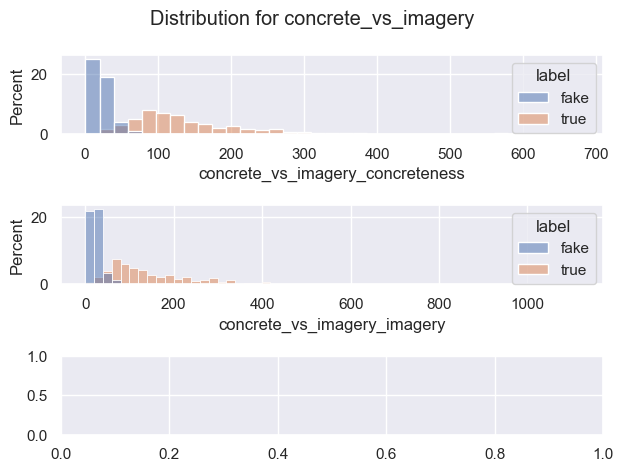

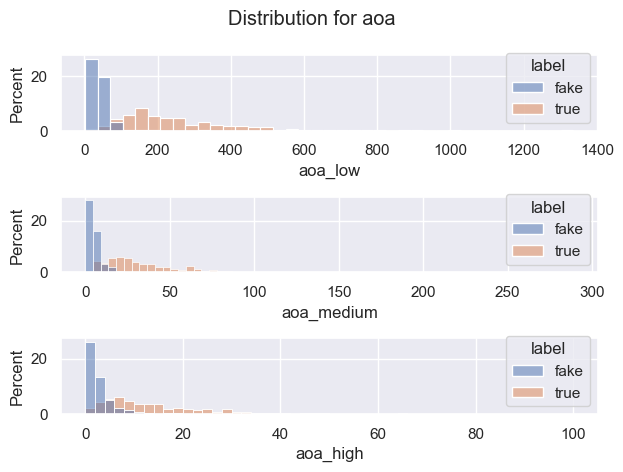

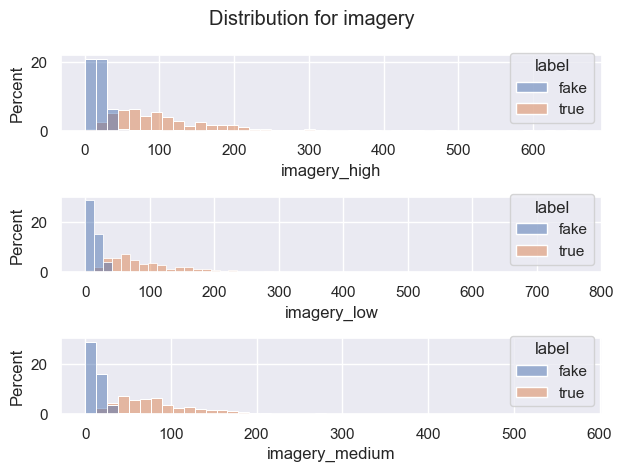

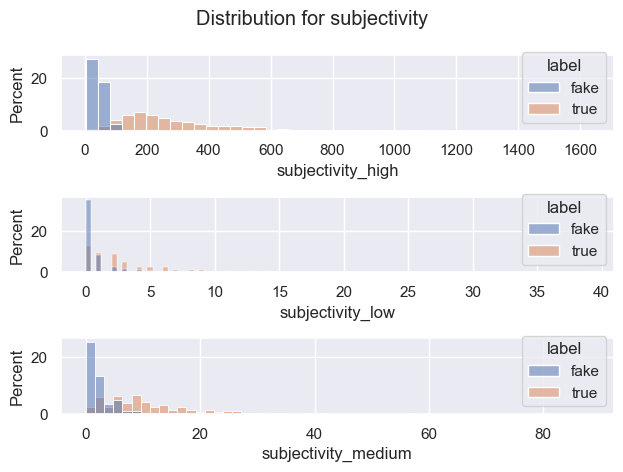

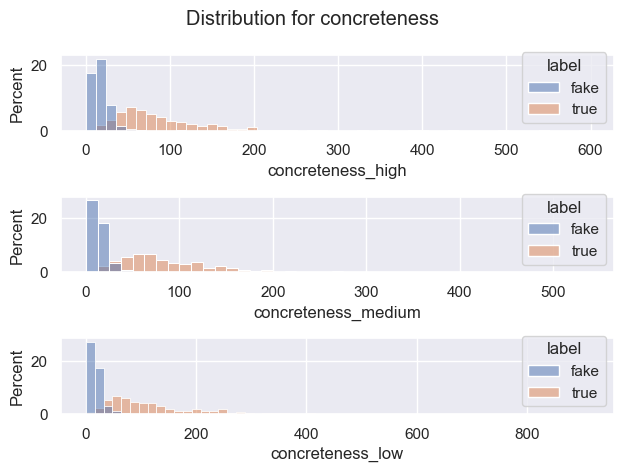

In [77]:
for feature in features:
    tmp = df_feature.filter(regex=rf'^{feature}')
    fig, axes = plt.subplots(3, 1)
    axes = np.ravel(axes)

    # levels = ['low', 'medium', 'high']
    colors = ['#56B4E9', '#E69F00', '#009E73']
    for ax, level in zip(axes, tmp.columns):
        sns.histplot(tmp, x=level, hue=df_feature['label'], stat='percent', ax=ax)
        ax.set_xlabel(level)
    plt.suptitle(f'Distribution for {feature}')
    plt.tight_layout()

In [18]:
sns.color_palette(palette='Paired')

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

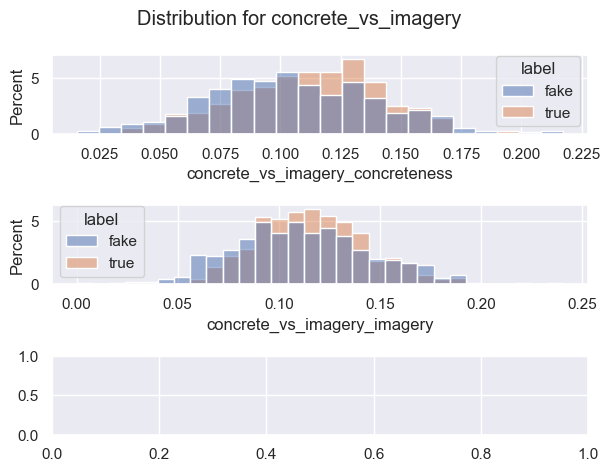

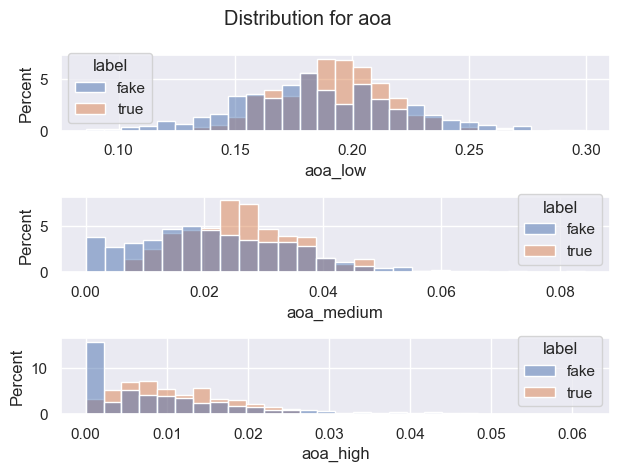

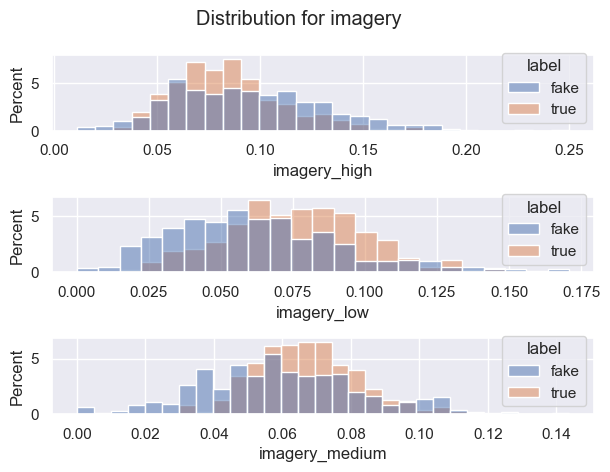

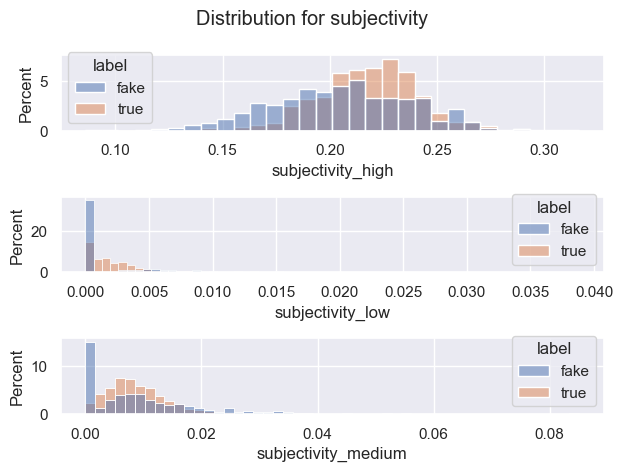

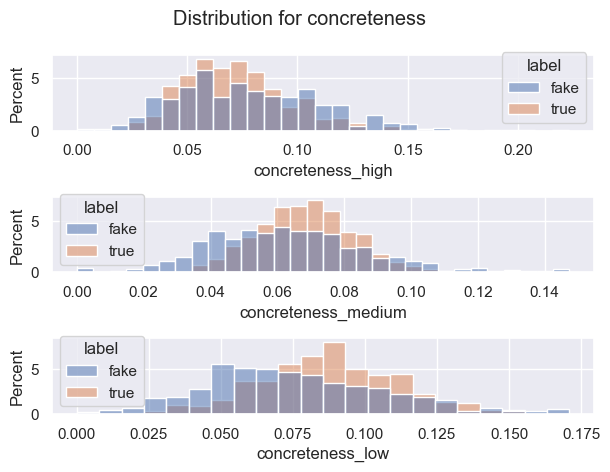

In [78]:
for feature in features:
    tmp = df_feature.filter(regex=rf'^{feature}')
    tmp = tmp.divide(df_feature['len'], axis=0)
    fig, axes = plt.subplots(3, 1)
    axes = np.ravel(axes)

    # levels = ['low', 'medium', 'high']
    colors = ['#56B4E9', '#E69F00', '#009E73']
    for ax, level in zip(axes, tmp.columns):
        sns.histplot(tmp, x=level, hue=df_feature['label'], stat='percent', ax=ax)
        ax.set_xlabel(level)
    plt.suptitle(f'Distribution for {feature}')
    plt.tight_layout()

<Figure size 1000x1000 with 0 Axes>

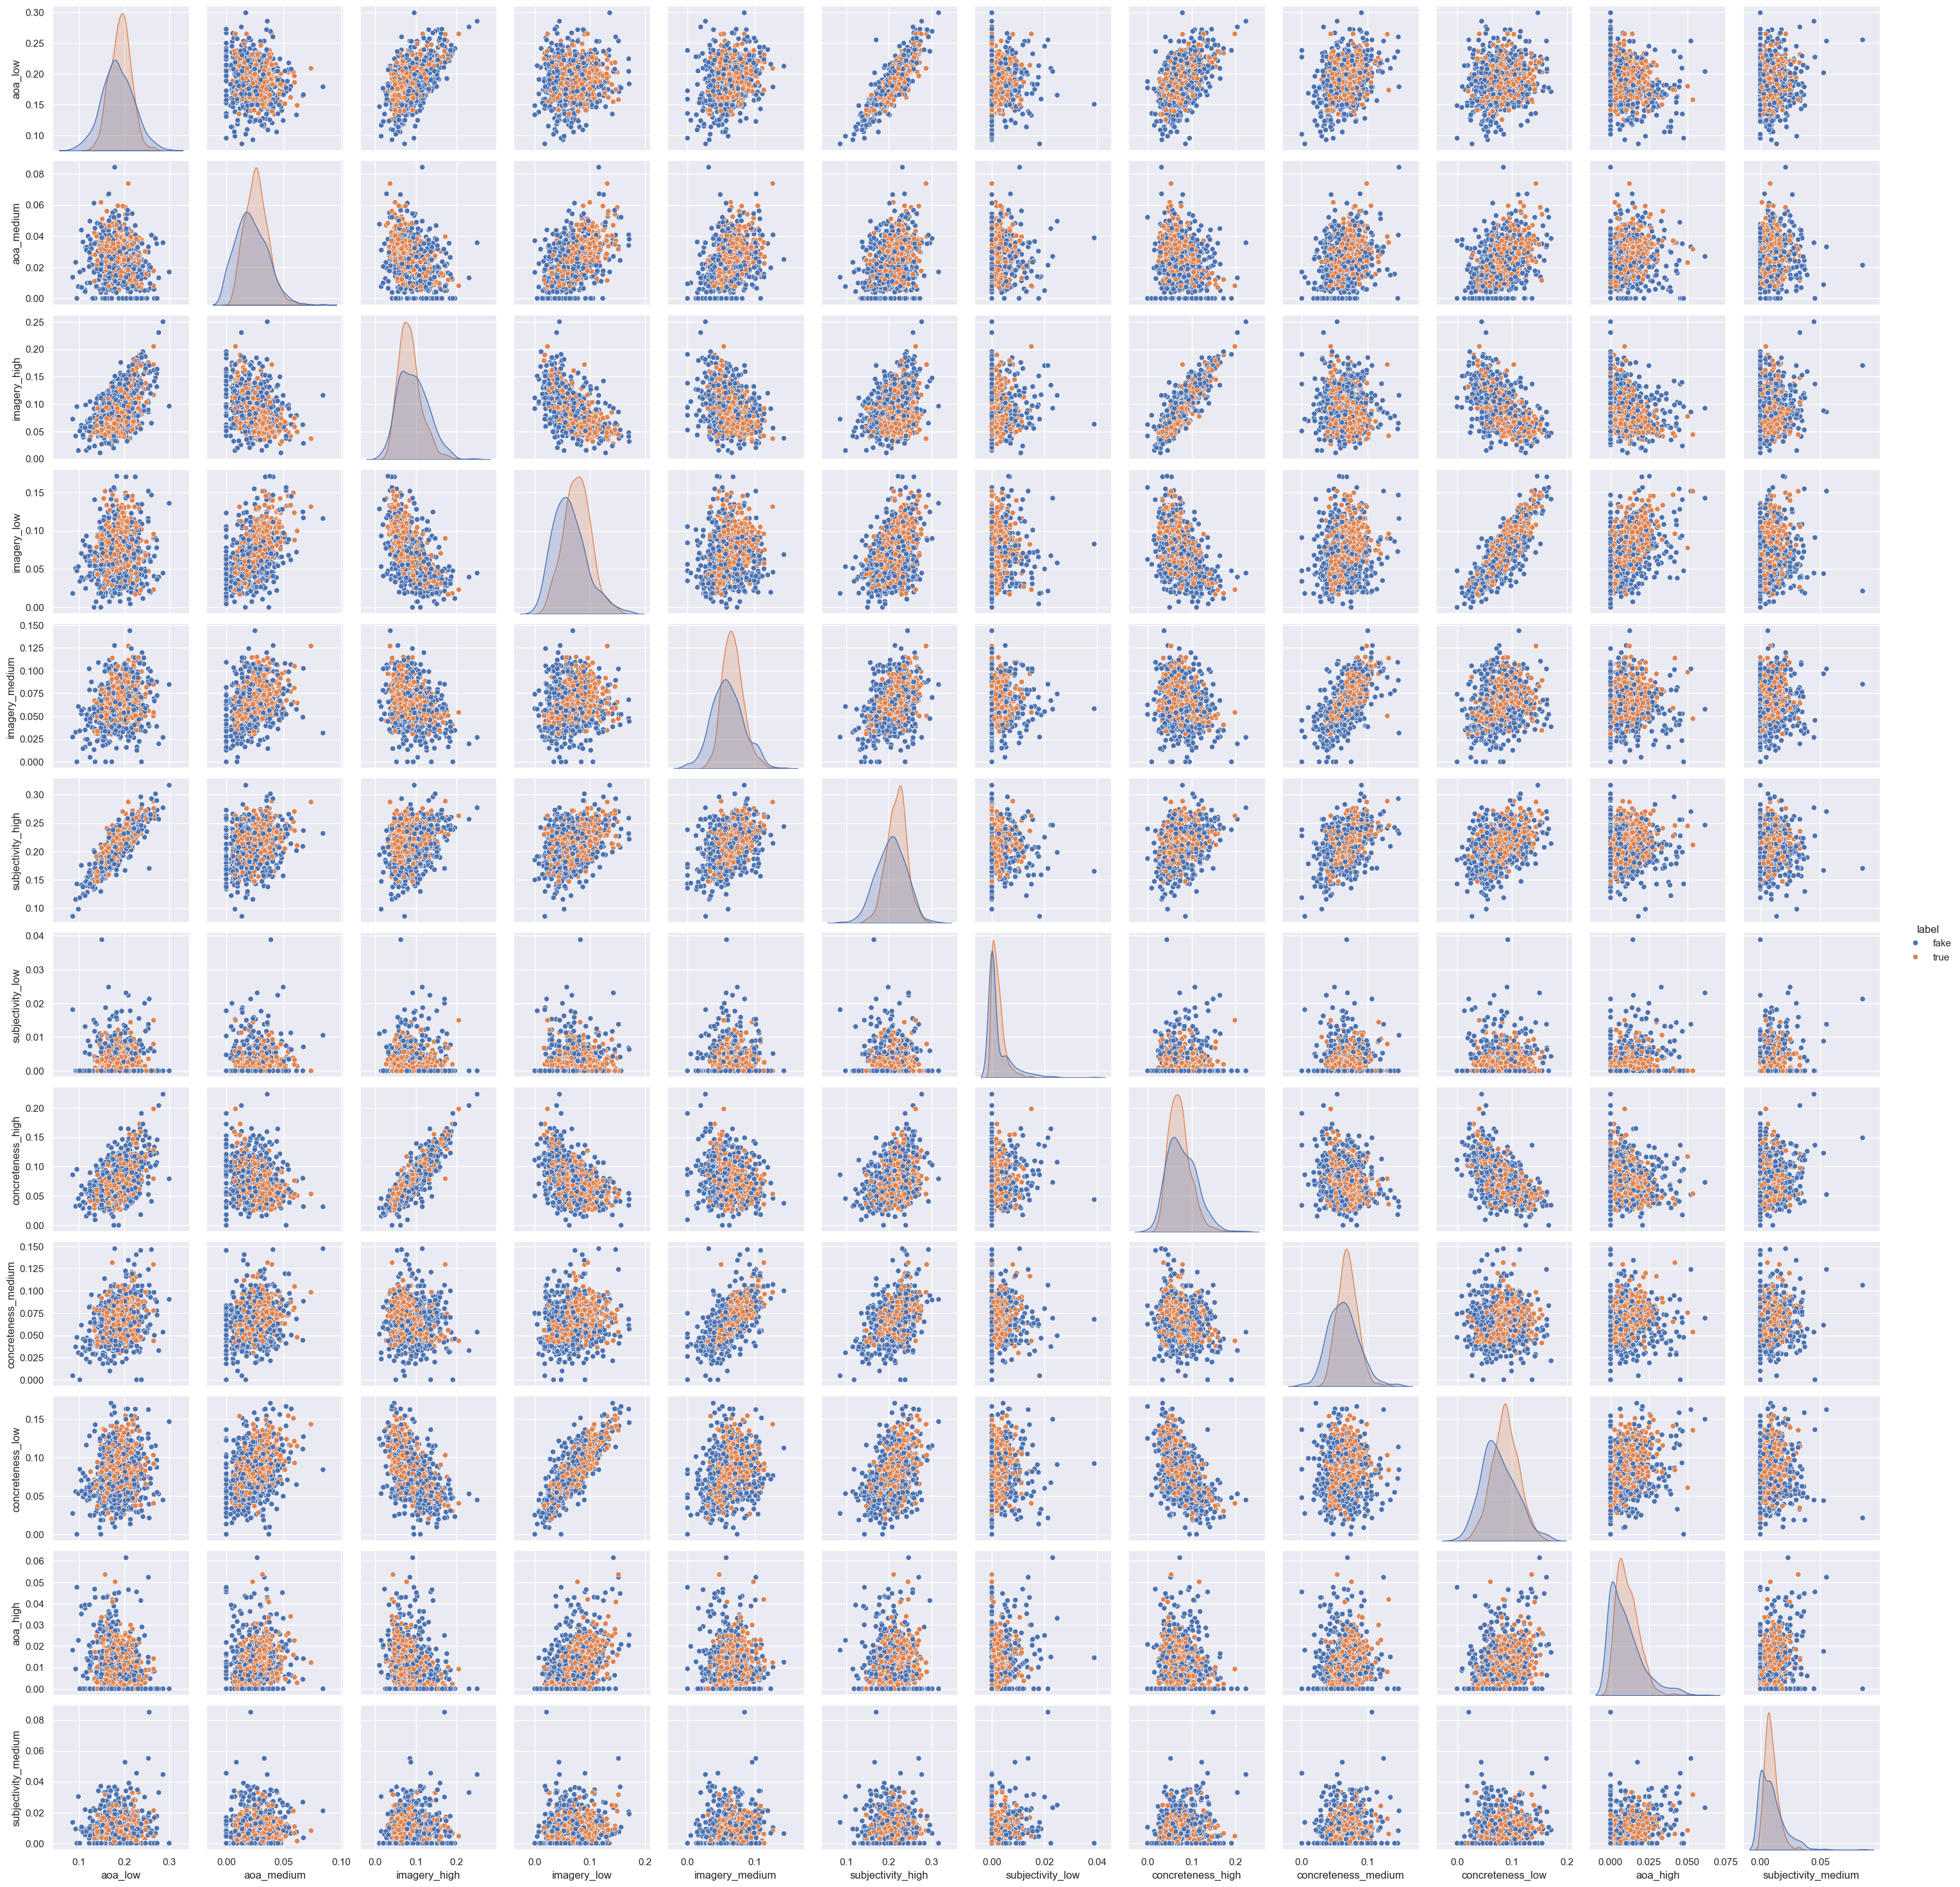

In [79]:
fig = plt.figure(figsize=(10, 10))
pattern = r'(low|medium|high)$'
tmp = df_feature.filter(regex=pattern).divide(df_feature['len'], axis=0)
tmp['label'] = df_feature['label']

sns.pairplot(tmp, hue='label')

In [99]:
from sklearn import tree
from sklearn.model_selection import train_test_split

cls_label = {'fake' : 1, 'true' : 0}

X =  df_feature.filter(regex=pattern).divide(df_feature['len'], axis=0)
y = df_feature['label'].apply(cls_label.get)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


clf = tree.DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)

clf

(800, 12)
(800,)
(200, 12)
(200,)


DecisionTreeClassifier(max_depth=3)

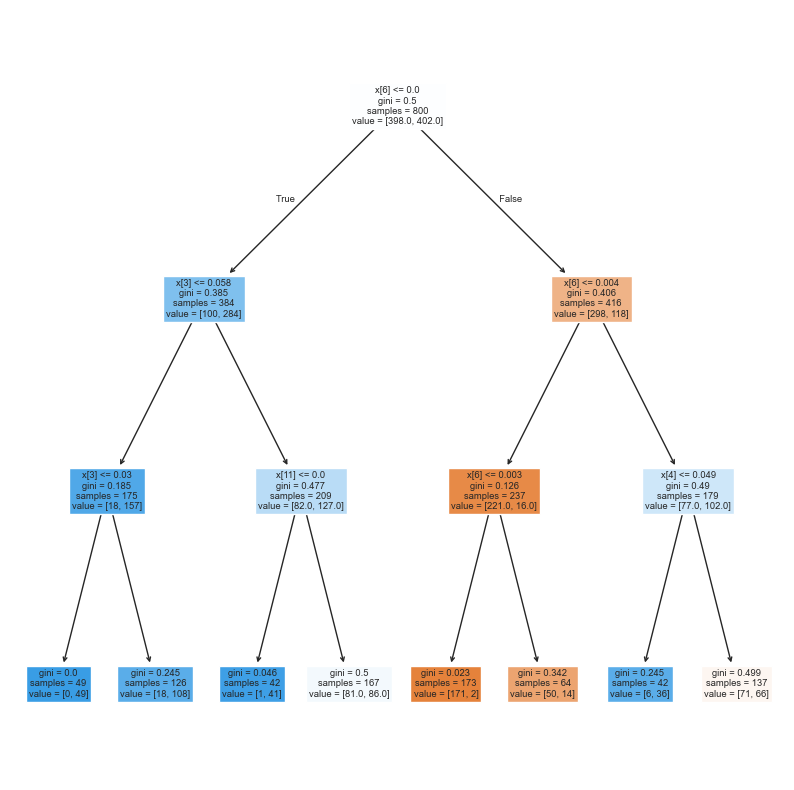

In [100]:
fig = plt.figure(figsize=(10, 10))
tree.plot_tree(clf, filled=True);

In [101]:
print(tree.export_text(clf, feature_names=X_train.columns))

|--- subjectivity_low <= 0.00
|   |--- imagery_low <= 0.06
|   |   |--- imagery_low <= 0.03
|   |   |   |--- class: 1
|   |   |--- imagery_low >  0.03
|   |   |   |--- class: 1
|   |--- imagery_low >  0.06
|   |   |--- subjectivity_medium <= 0.00
|   |   |   |--- class: 1
|   |   |--- subjectivity_medium >  0.00
|   |   |   |--- class: 1
|--- subjectivity_low >  0.00
|   |--- subjectivity_low <= 0.00
|   |   |--- subjectivity_low <= 0.00
|   |   |   |--- class: 0
|   |   |--- subjectivity_low >  0.00
|   |   |   |--- class: 0
|   |--- subjectivity_low >  0.00
|   |   |--- imagery_medium <= 0.05
|   |   |   |--- class: 1
|   |   |--- imagery_medium >  0.05
|   |   |   |--- class: 0



In [102]:
clf.score(X_train, y_train)

0.765

In [103]:
clf.score(X_test, y_test)

0.73